# Power Plant Energy Output Prediction : Weekend Hackathon #13

The dataset was collected from a Combined Cycle Power Plant over 6 years (2006-2011) when the power plant was set to work with a full load. Features consist of hourly average ambient variables Temperature (T), Ambient Pressure (AP), Relative Humidity (RH), and Exhaust Vacuum (V) to predict the net hourly electrical energy output (PE) of the plant.
A combined-cycle power plant (CCPP) is composed of gas turbines (GT), steam turbines (ST), and heat recovery steam generators.

In a CCPP, the electricity is generated by gas and steam turbines, which are combined in one cycle, and is transferred from one turbine to another. While the Vacuum is collected from and has an effect on the Steam Turbine, the other three of the ambient variables affect the GT performance.

##### Attribute Information:

Features consist of hourly average ambient variables

    -Temperature (AT) in the range 1.81°C and 37.11°C
    -Ambient Pressure (AP) in the range 992.89-1033.30 millibar
    -Relative Humidity (RH) in the range of 25.56% to 100.16%
    -Exhaust Vacuum (V) in the range 25.36-81.56 cm Hg
    -Net hourly electrical energy output (PE) 420.26-495.76 MW

The averages are taken from various sensors located around the plant that record the ambient variables every second. The variables are given without normalization.

### Rank 6 Solution

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("fivethirtyeight")
from pylab import rcParams

import warnings
warnings.filterwarnings("ignore")

import os
os.chdir("C:\\Users\\tamil\\OneDrive\\Documents\\Python Directory")

pd.set_option("display.max_rows",None)
pd.set_option("display.max_columns",None)

folder = "mh energy/"

In [2]:
train = pd.read_csv(folder+"Train.csv")
test = pd.read_csv(folder+"Test.csv")

In [3]:
print(f"Train set dim :\n{train.shape}")
print(f"Test set dim :\n{test.shape}")

Train set dim :
(9568, 5)
Test set dim :
(38272, 4)


In [4]:
train.head(3)

,AT,V,AP,RH,PE
0,29.07,72.51,1009.24,58.38,449.371855
1,32.38,67.17,1006.97,60.04,450.861043
2,19.29,67.71,1007.94,63.71,460.894029


0.3222961114988882


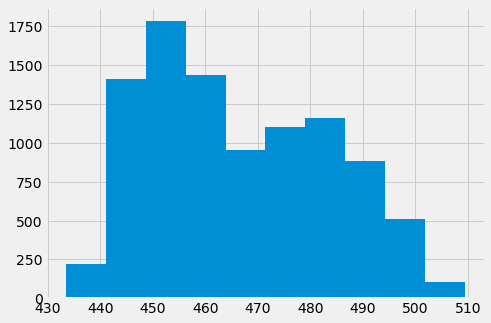

In [5]:
plt.rcParams["figure.figsize"] = 7,5
print(train["PE"].skew())
train["PE"].hist();

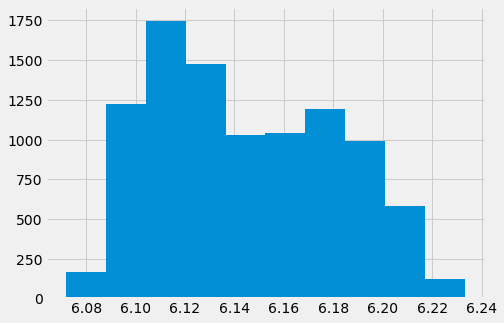

In [6]:
plt.rcParams["figure.figsize"] = 7,5
np.log(train["PE"]).hist();

No major change

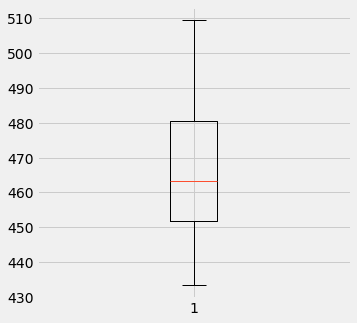

In [7]:
plt.rcParams["figure.figsize"] = 5,5
plt.boxplot(train["PE"]);

In [8]:
train_ind = train.drop("PE", axis = 1)
df = pd.concat([train_ind, test], axis = 0)

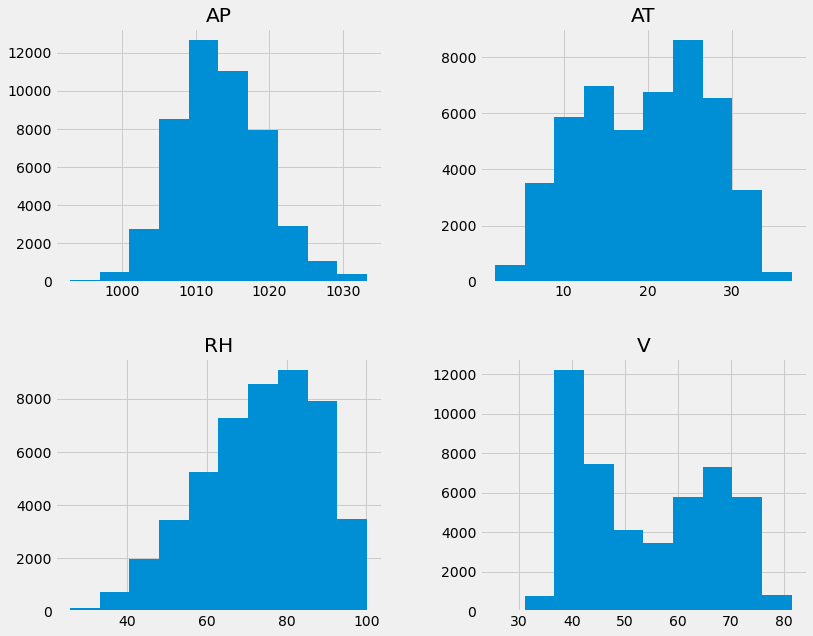

In [9]:
plt.rcParams["figure.figsize"] = 12,10
df.hist();

In [10]:
df.describe()

,AT,V,AP,RH
count,47840.000000,47840.000000,47840.000000,47840.000000
mean,19.651231,54.305804,1013.259078,73.308978
std,7.452162,12.707362,5.938535,14.599658
min,1.810000,25.360000,992.890000,25.560000
25%,13.510000,41.740000,1009.100000,63.327500
50%,20.345000,52.080000,1012.940000,74.975000
75%,25.720000,66.540000,1017.260000,84.830000
max,37.110000,81.560000,1033.300000,100.160000


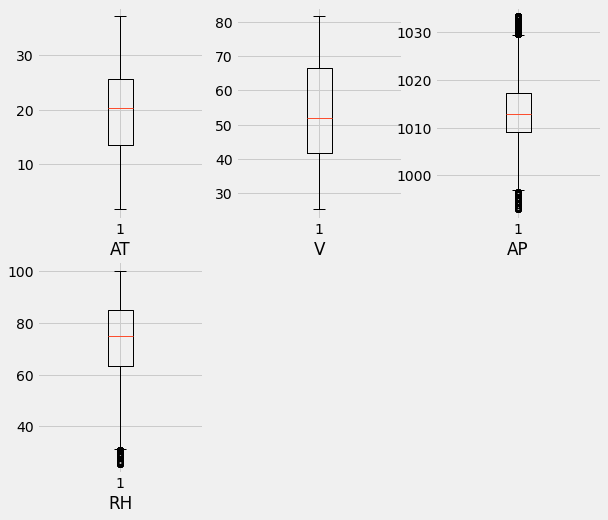

In [11]:
plt.rcParams["figure.figsize"] = 9,8
for i,col in enumerate(df.columns,1):
    plt.subplot(2,3,i)
    plt.boxplot(df[col])
    plt.xlabel(col)

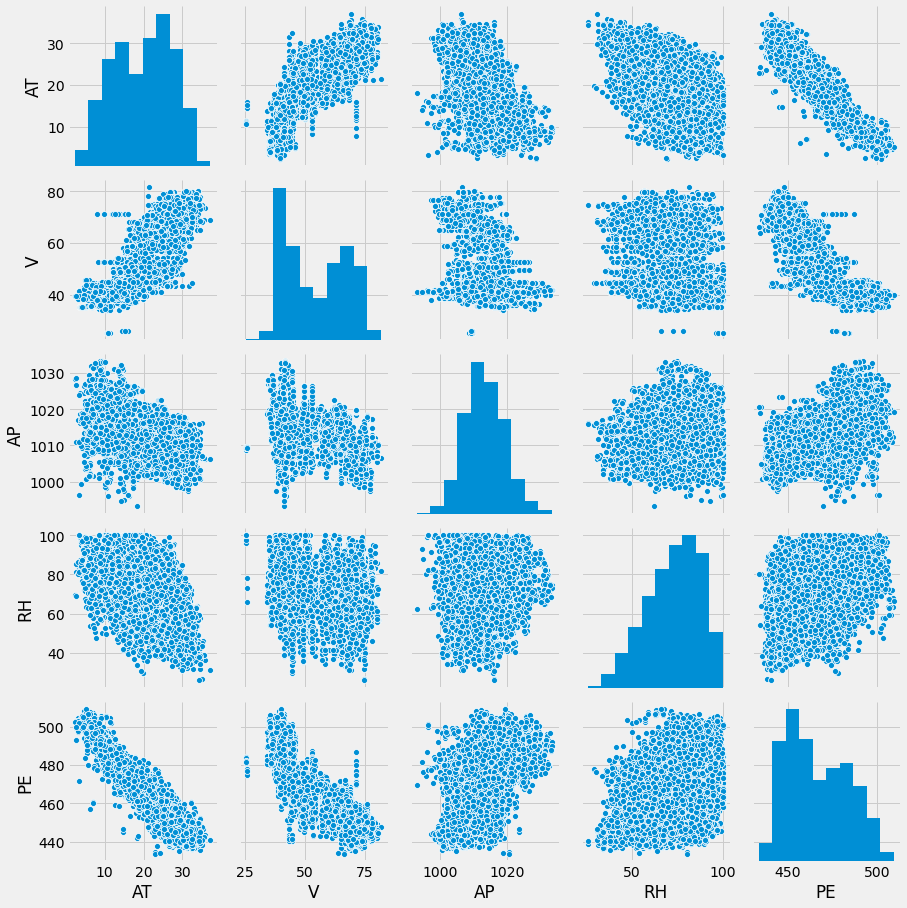

In [12]:
plt.rcParams["figure.figsize"] = 12,10
sns.pairplot(train);

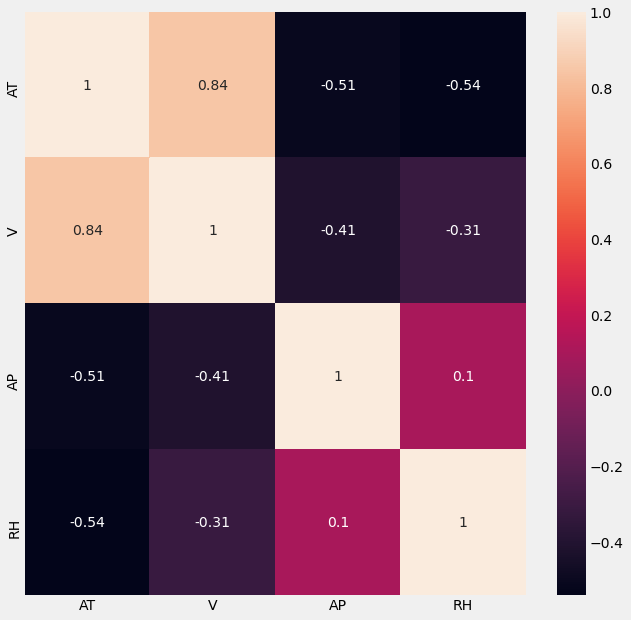

In [13]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot = True);

# New Features

In [14]:
#Pressure/Vaccum
df["AP_div_V"] = df["AP"]/df["V"]

In [15]:
def dew_point(AT,RH):
    
    """
    Dew Point: The atmospheric temperature (varying according to pressure and humidity) below which water 
    droplets begin to condense and dew can form.
    
    Oxford definition :P
    
    """
    
    dp = AT - ((100-RH)/5)
    return dp

df["Dew_Point"] = dew_point(df["AT"], df["RH"])
#Boosted my score

In [16]:
df["AT-RH"] = df["RH"] - df["AT"]

# Clustering - To generate new feature

In [17]:
from scipy.stats import zscore

std = df.apply(zscore)

In [18]:
std.head()

,AT,V,AP,RH,AP_div_V,Dew_Point,AT-RH
0,1.263911,1.432586,-0.676786,-1.022567,-1.249217,1.011482,-1.238096
1,1.708082,1.012353,-1.059040,-0.908865,-1.018620,1.584128,-1.321999
2,-0.048474,1.054848,-0.895698,-0.657486,-1.041241,-0.358655,-0.469744
3,-0.429575,-1.009331,0.569325,-1.924653,1.027347,-1.386965,-1.266063
4,0.238694,-0.577294,0.114663,-0.825985,0.399186,-0.099533,-0.703657


In [19]:
from sklearn.cluster import KMeans
def get_clusters(n):
    cluster = KMeans( n_clusters = n, random_state = 100 )
    cluster.fit(std)
        # To get the values of Centroid
    centroids = cluster.cluster_centers_
    centroid_df = pd.DataFrame(centroids, columns = list(std) )
    #print(centroid_df)
    prediction=cluster.predict(std)
    std["Cluster_Label"] = prediction
    print(std.head())
    data = std 
       
    def replace(group):
        median, std = group.median(), group.std() 
        outliers = (group - median).abs() > 2*std
        group[outliers] = group.median()       
        return group

    data_corrected = (data.groupby('Cluster_Label').transform(replace)) 
    concat_data = data_corrected.join(pd.DataFrame(std['Cluster_Label']))

In [20]:
get_clusters(6)

         AT         V        AP        RH  AP_div_V  Dew_Point     AT-RH  \
0  1.263911  1.432586 -0.676786 -1.022567 -1.249217   1.011482 -1.238096   
1  1.708082  1.012353 -1.059040 -0.908865 -1.018620   1.584128 -1.321999   
2 -0.048474  1.054848 -0.895698 -0.657486 -1.041241  -0.358655 -0.469744   
3 -0.429575 -1.009331  0.569325 -1.924653  1.027347  -1.386965 -1.266063   
4  0.238694 -0.577294  0.114663 -0.825985  0.399186  -0.099533 -0.703657   

   Cluster_Label  
0              3  
1              3  
2              1  
3              2  
4              2  


In [21]:
df = std.copy()

In [22]:
df.head(2)

,AT,V,AP,RH,AP_div_V,Dew_Point,AT-RH,Cluster_Label
0,1.263911,1.432586,-0.676786,-1.022567,-1.249217,1.011482,-1.238096,3
1,1.708082,1.012353,-1.059040,-0.908865,-1.018620,1.584128,-1.321999,3


In [23]:
df.describe()

,AT,V,AP,RH,AP_div_V,Dew_Point,AT-RH,Cluster_Label
count,4.784000e+04,4.784000e+04,4.784000e+04,4.784000e+04,4.784000e+04,4.784000e+04,4.784000e+04,47840.000000
mean,2.592518e-16,3.223035e-16,5.334798e-15,-3.101825e-16,3.212917e-16,-2.542020e-16,4.115931e-16,2.404369
std,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.735400
min,-2.394126e+00,-2.277901e+00,-3.430019e+00,-3.270589e+00,-1.588248e+00,-2.836032e+00,-3.171433e+00,0.000000
25%,-8.240958e-01,-9.888705e-01,-7.003615e-01,-6.836860e-01,-9.758670e-01,-8.050419e-01,-7.007328e-01,1.000000
50%,9.309729e-02,-1.751604e-01,-5.373067e-02,1.141150e-01,-6.326244e-02,1.506259e-01,1.099517e-01,3.000000
75%,8.143721e-01,9.627745e-01,6.737290e-01,7.891378e-01,9.852219e-01,8.105366e-01,7.633810e-01,4.000000
max,2.342804e+00,2.144779e+00,3.374760e+00,1.839173e+00,4.316520e+00,2.078785e+00,2.190755e+00,5.000000


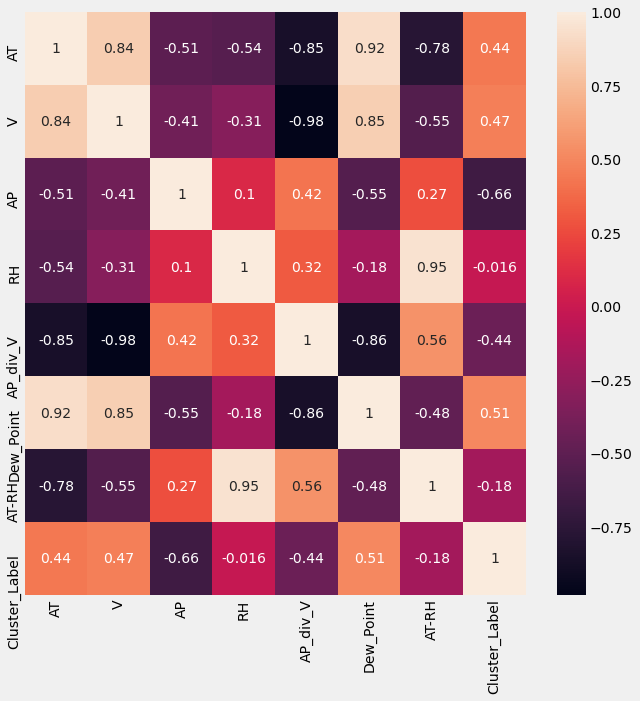

In [24]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot = True);

# Modeling

In [25]:
data_train = df[:train.shape[0]]
data_test = df[train.shape[0]:]

In [26]:
from sklearn.model_selection import train_test_split
X = data_train
Y = train["PE"]

train_x,test_x,train_y,test_y = train_test_split(X,Y,test_size = 0.30, random_state = 2020)

In [27]:
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit,cross_validate, StratifiedKFold,KFold
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor

In [28]:
xgboost = XGBRegressor(max_depth = 31, learning_rate = 0.15)
xgboost.fit(train_x, train_y)
pred_train = xgboost.predict(train_x)
print("Train RMSE = {0} ".format(np.sqrt(mean_squared_error((train_y),(pred_train)))))
pred_test = xgboost.predict(test_x)
print("Test RMSE = {0}".format(np.sqrt(mean_squared_error((test_y),(pred_test)))))

Train RMSE = 0.47886958700970317 
Test RMSE = 2.8481175846092097


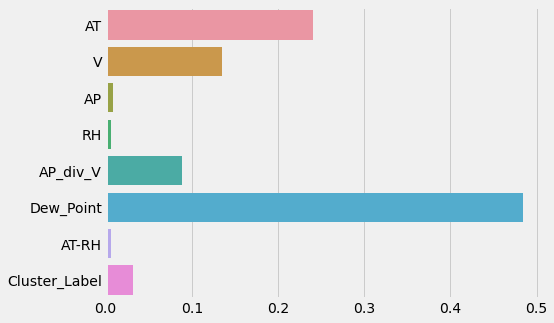

In [29]:
plt.figure(figsize=(7,5))
sns.barplot(xgboost.feature_importances_, X.columns)

In [30]:
err_xgb = []
y_pred_tot_xgb = []

# X = X[selected_col]

from sklearn.model_selection import StratifiedKFold

fold = KFold(n_splits=15, shuffle=True, random_state=100)
i = 1
for train_index, test_index in fold.split(X.values, Y.values):
    x_train, x_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = Y[train_index], Y[test_index]
    m = XGBRegressor(max_depth = 31, learning_rate = 0.15)
    m.fit(x_train, y_train)
    pred_y = m.predict(x_val)
    print(i, " err_XGB: ", np.sqrt(mean_squared_error(y_val, pred_y)))
    err_xgb.append(np.sqrt(mean_squared_error(y_val, pred_y)))
    pred_test = m.predict(data_test)
    i = i + 1
    y_pred_tot_xgb.append(pred_test)
    
print()    
print("XGB Mean RMSE : ", np.mean(err_xgb))

1  err_XGB:  2.179454335263295
2  err_XGB:  2.2233929747547263
3  err_XGB:  2.354170662668295
4  err_XGB:  2.311924320581651
5  err_XGB:  2.2796334490169663
6  err_XGB:  2.2383741602392586
7  err_XGB:  2.1116867484501647
8  err_XGB:  2.2906184329401778
9  err_XGB:  2.506206118044027
10  err_XGB:  2.3039422263193132
11  err_XGB:  2.440957289447324
12  err_XGB:  2.913398712030726
13  err_XGB:  2.5124953491188022
14  err_XGB:  2.4947761236313335
15  err_XGB:  2.2356024001705017

XGB Mean RMSE :  2.359775553511771


In [31]:
def RMSE(y_true, y_pred):
    return mean_squared_error(y_true, y_pred) ** 0.5

import time

features = X.columns

training_start_time = time.time()

max_iter = 10
folds = StratifiedKFold(n_splits = max_iter)
oofs = np.zeros(len(X))
test_preds = np.zeros(len(data_test))
actual_test_preds = np.zeros(len(test_x))



for fold_, (trn_idx, val_idx) in enumerate(folds.split(data_train, pd.qcut(Y, 10, labels=False, duplicates='drop'))):
    
    print(f'\n---- Fold {fold_} -----\n')
    
    fold_start_time = time.time()
    
    X_trn, y_trn = X.iloc[trn_idx][features], pd.Series(Y).iloc[trn_idx]
    X_val, y_val = X.iloc[val_idx][features], pd.Series(Y).iloc[val_idx]
    X_test = data_test[features]
    print(X_trn.shape[1], X_val.shape[1])
    

    clf = XGBRegressor(n_estimators = 1000,max_depth = 31, learning_rate = 0.15)
    _ = clf.fit(X_trn,(y_trn), eval_set = [(X_val, (y_val))], verbose=100, early_stopping_rounds=200, eval_metric='rmse')
    

    oofs[val_idx] = (clf.predict(X_val))
    current_test_pred = (clf.predict(X_test))
    test_preds += (clf.predict(X_test))/max_iter
    actual_test_preds += (clf.predict(test_x))/max_iter
    
    
    print(f'\n Fold {RMSE((y_val),(oofs[val_idx]))}')
    
    fold_end_time = time.time()
    total_fold_time = int(fold_end_time - fold_start_time)
    
    print(f"\n->-> Fold ran for {(total_fold_time)//60} minutes {(total_fold_time)%60} seconds")
    

print(f'\nOOF val score: {RMSE((pd.Series(Y)), (oofs))}')
training_end_time = time.time()
total_training_time = int(training_end_time - training_start_time)

print(f'\n->-> Total training time: {(total_training_time)//60} minutes {(total_training_time)%60} seconds')


---- Fold 0 -----

8 8
[0]	validation_0-rmse:396.45099
Will train until validation_0-rmse hasn't improved in 200 rounds.
[100]	validation_0-rmse:2.29212
[200]	validation_0-rmse:2.29329
Stopping. Best iteration:
[66]	validation_0-rmse:2.28617


 Fold 2.286164806853651

->-> Fold ran for 0 minutes 8 seconds

---- Fold 1 -----

8 8
[0]	validation_0-rmse:396.36017
Will train until validation_0-rmse hasn't improved in 200 rounds.
[100]	validation_0-rmse:2.40884
[200]	validation_0-rmse:2.40899
[300]	validation_0-rmse:2.40899
Stopping. Best iteration:
[114]	validation_0-rmse:2.40879


 Fold 2.408791188349326

->-> Fold ran for 0 minutes 8 seconds

---- Fold 2 -----

8 8
[0]	validation_0-rmse:396.23538
Will train until validation_0-rmse hasn't improved in 200 rounds.
[100]	validation_0-rmse:2.59388
[200]	validation_0-rmse:2.59421
Stopping. Best iteration:
[80]	validation_0-rmse:2.59244


 Fold 2.5924368821629162

->-> Fold ran for 0 minutes 8 seconds

---- Fold 3 -----

8 8
[0]	validation_0-r

# FINAL SUBMISSION

In [32]:
submission = pd.DataFrame()
submission["PE"] = test_preds #average of predictions
submission.to_csv(folder+"submission_final.csv",index = False)
print("Submission is ready")

submission.head()

Submission is ready


,PE
0,473.115112
1,494.926861
2,497.065048
3,480.322205
4,445.333679


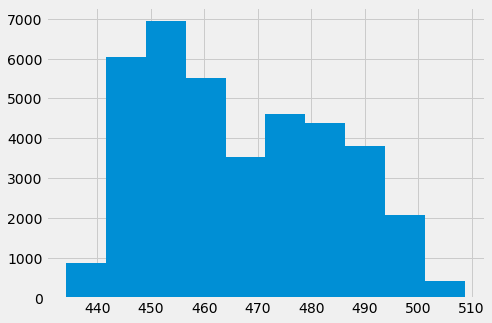

In [33]:
plt.rcParams["figure.figsize"] = 7,5
submission["PE"].hist();

In [34]:
submission["PE"].skew()

0.3100329642134342

# Thanks for reading